# testing without processor: edit features
Only `TTGamma` data, distinguishing prompt photons from fake photons

* `ak.flatten` instead of `ak.pad_none`
* Remove jet & muon features
* Remove 1 photon requirement. How to include `photon_count` feature?

In [1]:
from coffea import hist, util

#import coffea.processor as processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward as ak
import numpy as np
import uproot

import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

In [2]:
#Define files to run over
skimDir="/udrive/staff/dnoonan/Skims"

fileset = {"TTGamma":[f"{skimDir}/TTGamma_SingleLept_2016_skim.root"],
           "TTbar":[f"{skimDir}/TTbarPowheg_Semilept_2016_skim_1of10.root",
                    f"{skimDir}/TTbarPowheg_Semilept_2016_skim_2of10.root"],
          }

filesetData = {"DataMu":[f"{skimDir}/Data_SingleMu_b_2016_skim_1of10.root"],
              }

In [3]:
np.warnings.filterwarnings('ignore')

#the NanoAODSchema needs to be adjusted, to remove cross references to FSRPhotons
class SkimmedSchema(NanoAODSchema):
    def __init__(self, base_form):
        base_form["contents"].pop("Muon_fsrPhotonIdx", None)
        super().__init__(base_form)

In [4]:
# events from TTGamma
events = NanoEventsFactory.from_root(fileset["TTGamma"][0],
                                     schemaclass=SkimmedSchema,
                                     entry_stop=10000).events()

dataset = "TTGamma"

In [5]:
# photon cuts
photons = events.Photon
photonSelect= ((photons.pt>20) &
               (abs(photons.eta) < 1.4442) &
               (photons.isScEtaEE | photons.isScEtaEB) &
               (photons.electronVeto) & 
               np.invert(photons.pixelSeed)
               )
tightPhotons = photons[photonSelect]

In [6]:
# muon cuts
muons = events.Muon
muonSelectTight = ((muons.pt>30) &
                   (abs(muons.eta)<2.4) &
                   (muons.tightId) &
                   (muons.pfRelIso04_all < 0.15)
                  )
tightMuons = muons[muonSelectTight]

In [7]:
# jet & b-tagged jet cuts
jets = events.Jet

jetSelectTight = ((jets.pt>30) &
                  (abs(jets.eta)<2.4) &
                  (jets.isTight)
                 )
btaggedJetSelect = (jetSelectTight &
                   (jets.btagDeepB>0.6321)
                  )

tightJets = jets[jetSelectTight]
tightBJets = jets[btaggedJetSelect]

In [8]:
# electron cuts
electrons = events.Electron
electronSelectTight = ((electrons.pt> 35) &
                       (abs(electrons.eta)<2.1) &
                       (electrons.cutBased>=4)
                      )
tightEle = electrons[electronSelectTight]

In [9]:
## delta R using nearest
phoMu, phoMuDR   = tightPhotons.nearest(tightMuons,return_metric=True)
phoJet, phoJetDR = tightPhotons.nearest(tightJets,return_metric=True)

In [10]:
print('Pho:',tightPhotons)
print('Mu: ',tightMuons)
print('DR: ',phoMuDR)

# [] == no photon
# [None] == photon but no muon; will be removed by the event selection (ak.num(tightMuons)==1)

Pho: [[Photon], [], [], [Photon], [], ... [Photon], [Photon], [Photon], [Photon]]
Mu:  [[Muon], [], [], [Muon], [], [], [], ... [Muon], [], [Muon], [], [Muon], []]
DR:  [[1.87], [], [], [2.99], [], [None, None, ... [None], [4.26], [None], [2.6], [None]]


In [11]:
# event cuts
trigger = events.HLT.IsoMu24 | events.HLT.IsoTkMu24

eventSelection = (trigger &
                  (ak.num(tightMuons)==1) &
                  (ak.num(tightJets)>=4) & 
                  (ak.num(tightBJets)>=1) &
                  (ak.num(tightEle)==0) &
                  (ak.num(tightPhotons)>=1))

In [12]:
##### histograms #####

In [129]:
dataset_axis = hist.Cat("dataset","Dataset")

photon_pt_axis = hist.Bin("pt","photon $p_{T}$ [GeV]", 40, 0, 400)
photon_eta_axis = hist.Bin("eta","photon $\eta$", 50, -2.5, 2.5)
photon_phi_axis = hist.Bin("phi","photon $\phi$", 64, -3.2, 3.2)
photon_reliso_all_axis = hist.Bin("reliso","photon pfRelIso03_all", 40, -0.5, 6)
photon_reliso_chg_axis = hist.Bin("reliso","photon pfRelIso03_chg", 40, -0.5, 6)
photon_sieie_axis = hist.Bin("sieie","photon sigma I eta I eta", 40, 0, 0.05)
photon_r9_axis = hist.Bin("r9","photon R9", 40, -0.5, 1.5)
photon_hoe_axis = hist.Bin("hoe","photon H over E", 40, -0.5, 1)
photon_count_axis = hist.Bin("count","Photon number",12,-1,10)

deltar_axis = hist.Bin("deltar","$\Delta R$", 50, -0.5, 4)

mvaid_axis = hist.Bin("mvaid", "MVA ID", 50, -1, 1)

photon_genPartFlav_axis = hist.Bin("flav","genPartFlav",40,-1,15)

In [130]:
photon_pt_hist = hist.Hist("Counts", dataset_axis, photon_pt_axis)
photon_eta_hist = hist.Hist("Counts", dataset_axis, photon_eta_axis)
photon_phi_hist = hist.Hist("Counts", dataset_axis, photon_phi_axis)
photon_reliso_all_hist = hist.Hist("Counts", dataset_axis, photon_reliso_all_axis)
photon_reliso_chg_hist = hist.Hist("Counts", dataset_axis, photon_reliso_chg_axis)
photon_sieie_hist = hist.Hist("Counts", dataset_axis, photon_sieie_axis)
photon_r9_hist = hist.Hist("Counts", dataset_axis, photon_r9_axis)
photon_hoe_hist = hist.Hist("Counts", dataset_axis, photon_hoe_axis)
photon_count_hist = hist.Hist("Counts", dataset_axis, photon_count_axis)

deltaR_photon_lepton_hist = hist.Hist("Counts", dataset_axis, deltar_axis)
deltaR_photon_jet_hist = hist.Hist("Counts", dataset_axis, deltar_axis)

photon_mvaid_hist = hist.Hist("Counts", dataset_axis, mvaid_axis)

photon_genPartFlav_hist = hist.Hist("Counts", dataset_axis, photon_genPartFlav_axis)

In [131]:
photon_pt_hist.fill(dataset=dataset,
                    pt=ak.flatten(tightPhotons[eventSelection].pt))
photon_eta_hist.fill(dataset=dataset,
                     eta=ak.flatten(tightPhotons[eventSelection].eta))
photon_phi_hist.fill(dataset=dataset,
                     phi=ak.flatten(tightPhotons[eventSelection].phi))
photon_reliso_all_hist.fill(dataset=dataset,
                            reliso=ak.flatten(tightPhotons[eventSelection].pfRelIso03_all))
photon_reliso_chg_hist.fill(dataset=dataset,
                            reliso=ak.flatten(tightPhotons[eventSelection].pfRelIso03_chg))
photon_sieie_hist.fill(dataset=dataset,
                       sieie=ak.flatten(tightPhotons[eventSelection].sieie))
photon_r9_hist.fill(dataset=dataset,
                    r9=ak.flatten(tightPhotons[eventSelection].r9))
photon_hoe_hist.fill(dataset=dataset,
                     hoe=ak.flatten(tightPhotons[eventSelection].hoe))
photon_count_hist.fill(dataset=dataset,
                       count=(ak.num(tightPhotons[eventSelection])))

deltaR_photon_lepton_hist.fill(dataset=dataset,
                               deltar=ak.flatten(phoMuDR[eventSelection]))
deltaR_photon_jet_hist.fill(dataset=dataset,
                            deltar=ak.flatten(phoJetDR[eventSelection]))

photon_mvaid_hist.fill(dataset=dataset,
                      mvaid=ak.flatten(tightPhotons[eventSelection].mvaID))

photon_genPartFlav_hist.fill(dataset=dataset,
                             flav=ak.flatten(tightPhotons[eventSelection].genPartFlav))

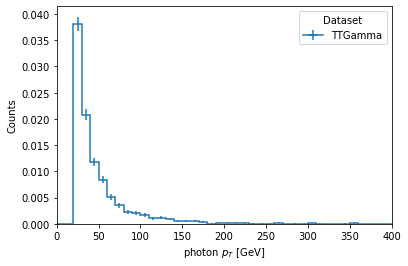

In [132]:
hist.plot1d(photon_pt_hist,overlay='dataset',stack=False,density=True)
plt.show()

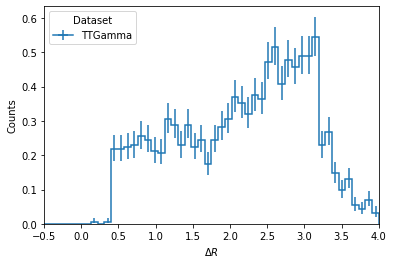

In [133]:
hist.plot1d(deltaR_photon_lepton_hist,overlay='dataset',stack=False,density=True)
plt.show()

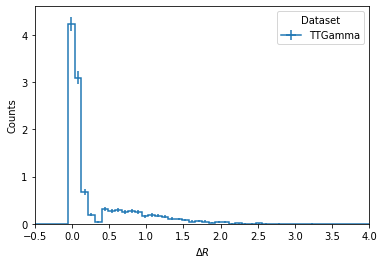

In [134]:
hist.plot1d(deltaR_photon_jet_hist,overlay='dataset',stack=False,density=True)
plt.show()

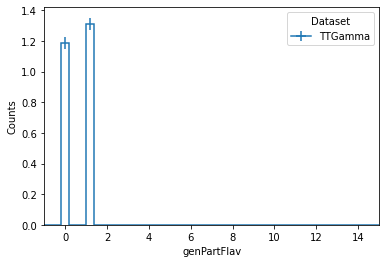

In [135]:
hist.plot1d(photon_genPartFlav_hist,overlay='dataset',stack=False,density=True)
plt.show()

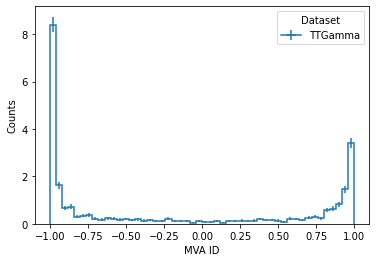

In [161]:
hist.plot1d(photon_mvaid_hist,overlay='dataset',stack=False,density=True)
plt.xlim(-1.1, 1.1)
plt.show()

# -1 is background, 1 is signal?

In [137]:
###### column accumulators #######

In [138]:
photon_pt = ak.to_numpy(ak.flatten(tightPhotons.pt[eventSelection]))
photon_eta = ak.to_numpy(ak.flatten(tightPhotons.eta[eventSelection]))
photon_phi = ak.to_numpy(ak.flatten(tightPhotons.phi[eventSelection]))
photon_pfRelIso03_all = ak.to_numpy(ak.flatten(tightPhotons.pfRelIso03_all[eventSelection]))
photon_pfRelIso03_chg = ak.to_numpy(ak.flatten(tightPhotons.pfRelIso03_chg[eventSelection]))
photon_sieie = ak.to_numpy(ak.flatten(tightPhotons.sieie[eventSelection]))
photon_r9 = ak.to_numpy(ak.flatten(tightPhotons.r9[eventSelection]))
photon_hoe = ak.to_numpy(ak.flatten(tightPhotons.hoe[eventSelection]))

dim = ak.to_numpy(ak.num(tightPhotons[eventSelection]))
photon_count = ak.to_numpy(ak.num(tightPhotons[eventSelection]))

deltaR_photon_lepton = ak.to_numpy(ak.flatten(phoMuDR[eventSelection]))
deltaR_photon_jet = ak.to_numpy(ak.flatten(phoJetDR[eventSelection]))

photon_mvaid = ak.to_numpy(ak.flatten(tightPhotons.mvaID[eventSelection]))

photon_genPartFlav = ak.to_numpy(ak.flatten(tightPhotons.genPartFlav[eventSelection]))


In [139]:
photon_count.shape
# (2931,) more than other features; includes events with 0 photons.

# new event cut: not Exactly one photon, but At Least one photon
# (1568,) less than other features; one entry per event, not one entry per photon....

(1568,)

In [140]:
dim = ak.to_numpy(ak.num(tightPhotons[eventSelection]))
print(dim) # number photons in each event
print(dim.shape) # number of events

[1 1 1 ... 1 1 1]
(1568,)


In [141]:
ak.to_numpy(ak.flatten(tightPhotons[eventSelection])).shape # number of photons

(2055,)

In [142]:
photon_pt.shape

(2055,)

In [143]:
np.array(photon_pt)

array([25.824781, 35.281075, 34.028465, ..., 20.967505, 41.821255,
       26.404654], dtype=float32)

In [144]:
np.array(photon_pt).shape

(2055,)

In [145]:
np.array(deltaR_photon_lepton).shape

(2055,)

In [146]:
####### processing for machine learning #######

In [147]:
df = pd.DataFrame({
    'photon_pt': np.array(photon_pt),
    'photon_eta': np.array(photon_eta),
    'photon_phi': np.array(photon_phi),
    'photon_hoe': np.array(photon_hoe),
    'photon_r9': np.array(photon_r9),
    'photon_sieie': np.array(photon_sieie),
    'photon_pfRelIso03_all': np.array(photon_pfRelIso03_all),
    'photon_pfRelIso03_chg': np.array(photon_pfRelIso03_chg),
    #'photon_count': np.array(photon_count), ### different shape than other features...
    
    'deltaR_photon_lepton': np.array(deltaR_photon_lepton),
    'deltaR_photon_jet': np.array(deltaR_photon_jet),
    
    # don't add mvaID
    
    'photon_genPartFlav': np.array(photon_genPartFlav),  ## target ##
})
df.describe()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet,photon_genPartFlav
count,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000
mean,48.474655,0.024479,0.007559,0.129705,0.782890,0.011623,0.646297,0.373496,2.177051,0.297218,0.524574
std,39.497158,0.760451,1.853572,0.156695,0.215450,0.003650,0.945536,0.591014,0.890150,0.467399,0.499517
min,20.004259,-1.442871,-3.138672,0.000000,0.129883,0.005245,0.000000,0.000000,0.183863,0.000918,0.000000
25%,25.424696,-0.579834,-1.627808,0.000000,0.626953,0.009075,0.025289,0.000012,1.434037,0.027178,0.000000
50%,35.093094,0.060707,0.030689,0.045776,0.859375,0.009697,0.320387,0.154447,2.322280,0.058377,1.000000
75%,54.826731,0.640015,1.621460,0.239990,0.956787,0.014214,0.927794,0.558635,2.889629,0.433081,1.000000
max,426.615692,1.441895,3.138672,1.390625,2.923828,0.025757,16.187374,11.755681,4.260221,3.276965,1.000000


In [148]:
df.head()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet,photon_genPartFlav
0,25.824781,1.385986,-2.261719,0.316406,0.351318,0.014465,0.817928,0.139733,2.986634,0.066809,0
1,35.281075,1.013672,-2.959961,0.024109,0.959473,0.010345,0.018126,0.000000,0.673868,0.433896,1
2,34.028465,-0.209381,-0.227020,0.043335,0.978516,0.009865,0.220662,0.093838,1.225805,0.020247,1
3,34.655228,-0.513184,-1.999023,0.000000,0.879395,0.009201,0.057543,0.057543,2.648314,0.010161,1
4,75.310669,0.780151,0.138641,0.260742,0.740234,0.018509,0.379569,0.131420,1.149185,0.017778,0


In [149]:
# split into features and labels
X = np.array(df.drop(['photon_genPartFlav'],axis=1))
y = df['photon_genPartFlav']

# shuffle & split into training, validation, testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

print(X_train.shape)
print(y_train.max())
print(y_train.min())

(1233, 10)
1
0


In [150]:
# Scale: mean=0, stdev=1
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)

In [151]:
model = Sequential()
model.add(Dense(32, input_shape=(X_train.shape[1],), activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1,activation="sigmoid"))

model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                352       
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________


In [152]:
model.fit(X_train_scaled, y_train, epochs=20, batch_size=128)

Epoch 1/20
10/10 [==============================] - 0s 1ms/step - loss: 0.6961 - accuracy: 0.5361
Epoch 2/20
10/10 [==============================] - 0s 1ms/step - loss: 0.5879 - accuracy: 0.7242
Epoch 3/20
10/10 [==============================] - 0s 2ms/step - loss: 0.5061 - accuracy: 0.8143
Epoch 4/20
10/10 [==============================] - 0s 2ms/step - loss: 0.4401 - accuracy: 0.8532
Epoch 5/20
10/10 [==============================] - 0s 2ms/step - loss: 0.3865 - accuracy: 0.8759
Epoch 6/20
10/10 [==============================] - 0s 1ms/step - loss: 0.3417 - accuracy: 0.8873
Epoch 7/20
10/10 [==============================] - 0s 1ms/step - loss: 0.3048 - accuracy: 0.8970
Epoch 8/20
10/10 [==============================] - 0s 1ms/step - loss: 0.2765 - accuracy: 0.9051
Epoch 9/20
10/10 [==============================] - 0s 1ms/step - loss: 0.2536 - accuracy: 0.9108
Epoch 10/20
10/10 [==============================] - 0s 1ms/step - loss: 0.2355 - accuracy: 0.9189
Epoch 11/20
10/10 [

In [153]:
loss, accuracy = model.evaluate(X_test_scaled,y_test,verbose=0)
print(f'Test loss: {round(loss,5)}\nTest accuracy: {round(accuracy,5)}')

Test loss: 0.21803
Test accuracy: 0.91484


In [154]:
y_pred = model.predict(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
area_under_curve = auc(fpr, tpr)

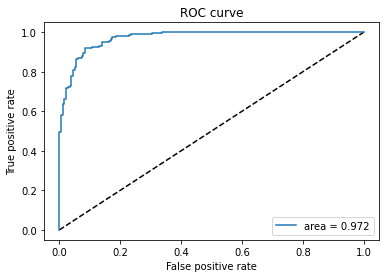

In [155]:
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='area = {:.3f}'.format(area_under_curve))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [156]:
predTrue  = y_pred[y_test==True]
predFalse = y_pred[y_test==False]

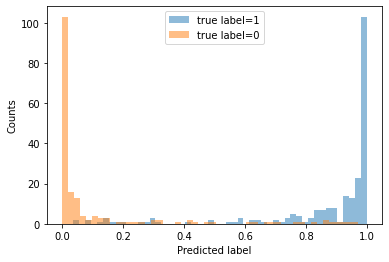

In [157]:
plt.hist(predTrue,bins=50,alpha=0.5,label='true label=1')
plt.hist(predFalse,bins=50,alpha=0.5,label='true label=0')

plt.xlabel('Predicted label')
plt.ylabel('Counts')
plt.title('')
plt.legend(loc='best')
plt.show()

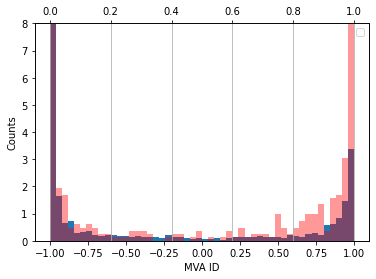

In [160]:
# compare mvaID labels

fig, ax1 = plt.subplots()

hist.plot1d(photon_mvaid_hist,stack=True,density=True,ax=ax1)
ax1.legend('')
ax1.set_xlim(-1.1,1.1)

ax2 = ax1.twiny()
ax2.hist(y_pred,bins=50,density=True,alpha=0.4,color="red",align="mid")

plt.ylim(0,8)
plt.grid()
plt.show()